#г)

In [ ]:
from scipy.stats import multivariate_normal
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import integrate
from numpy import vectorize

In [18]:
m = 1000
n = 10
d = 2
sigma = 1
Z = multivariate_normal.rvs(mean = None, cov =  np.identity(d), size = m)
W = np.random.random([n, d])
eps = multivariate_normal.rvs(mean = None, cov = sigma * np.identity(n), size = m)
X = Z.dot(W.T) + eps

In [21]:
pca = PCA(n_components = d)
pca.fit(X)
Z_common = pca.transform(X)

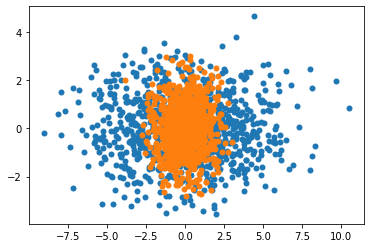

In [65]:
plt.scatter(Z_common[:,0], Z_common[:,1], lw=0.001)
plt.scatter(Z[:,0], Z[:,1], lw=0.001)
plt.show()

In [66]:
def E_step(X, W, mu, sigmaq):
  H = np.linalg.inv(W.T.dot(W) + sigmaq*np.identity(d))
            
  M = np.zeros([m, d])
  for k in range(m):
    M[k] = (H.dot(W.T).dot((X[k]-mu).reshape([-1,1]))).reshape(-1)
  return M, H

def M_step(X, M, H, W, mu, sigam):
  mu_new = np.mean(X, axis = 0)

  W_1 = np.zeros([n, d])
  W_2 = np.zeros([d, d])
  for k in range(m):
    W_1 += (X[k]-mu_new).reshape([-1,1]).dot(M[k].reshape([1,-1]))
    W_2 += M[k].reshape([-1,1]).dot(M[k].reshape([1,-1]))
            
  W_new = W_1.dot(np.linalg.inv(m*sigmaq*H + W_2))
        
  s_1 = s_2 = s_3 = 0
  for k in range(m):
    s_1 += M[k].reshape([1,-1]).dot(W_new.T).dot(W_new.dot(M[k].reshape([-1,1])))
    s_2 += ((mu_new-X[k]).reshape([1,-1]).dot((mu_new-X[k]).reshape([-1,1]))).reshape(-1)     
    s_3 += (M[k].reshape([1,-1]).dot(W_new.T).dot((X[k]-mu_new).reshape([-1,1]))).reshape(-1)  
  s_1 += m*np.trace(W_new.T.dot(W_new.dot(sigmaq*H)))
            
  sigmaq_new = float((s_1+s_2-2*s_3))/(m*n)
  return W_new, mu_new, sigmaq_new

In [67]:
W_init = np.random.random([n, d])
mu_init = np.mean(X, axis = 0)
sigma_init = 1
n_epoch = 300

In [ ]:
W_bayes = W_init
mu_bayes = mu_init
sigmaq_bayes = sigma_init**2
for i in range(n_epoch):
  M, H = E_step(X, W_bayes, mu_bayes, sigmaq_bayes)
  W_bayes, mu_bayes, sigmaq_bayes = M_step(X, M, H, W_bayes, mu_bayes, sigmaq_bayes)

In [56]:
# предсказание Z

H = np.linalg.inv(W_bayes.T.dot(W_bayes) + sigmaq_bayes*np.identity(d))
Z_bayes = np.zeros([X.shape[0], d])
for i in range(m):
  mean = (H.dot(W_bayes.T).dot((X[i] - mu_bayes).reshape([-1,1]))).reshape(-1)
  Z_bayes[i] = np.random.multivariate_normal(mean = mean, cov = sigmaq_bayes*H)

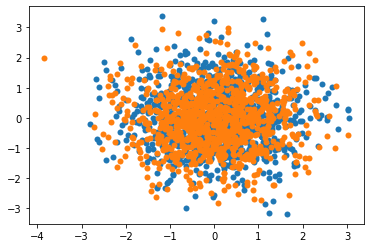

In [64]:
plt.scatter(Z_bayes[:,0], Z_bayes[:,1], lw=0.001)
plt.scatter(Z[:,0], Z[:,1], lw=0.001)
plt.show()

#е)

In [84]:
def E_step(X, mu, sigma, alpha, U, E_WTW, E_zzT, B_WS):
  H = np.linalg.inv(E_WTW + sigma*np.identity(n_comp))
  R = sigma*H
  for k in range(m):
    M[k] = (H.dot(U.T).dot((X[k] - mu).reshape([-1,1]))).reshape(-1)
  for k in range(m):
    E_zzT[k] = R + M[k].reshape([-1,1]).dot(M[k].reshape([1,-1]))
    
  B = np.sum(E_zzT, axis = 0)
  for k in range(n):
    B_WS[k] = np.linalg.inv(B + sigma*np.diag(alpha))
  B = sigma*B_WS

  U_1 = 0
  for k in range(m):
    U_1 += (X[k]-mu).reshape([-1,1]).dot(M[k].reshape([1,-1]))
  U_2 = np.linalg.inv(np.sum(E_zzT, axis = 0) + sigma*np.diag(alpha))
  U = U_1.dot(U_2)
  E_WTW = np.diag(np.sum(np.diagonal(B, axis1=1, axis2=2), axis = 1)) + np.diag(np.diagonal(U.T.dot(U)))

  return mu, sigma, alpha, B, U, E_WTW, E_zzT

def M_step(X, mu, sigma, alpha, B, U, E_WTW, E_zzT):
  for k in range(n):
    alpha[k] = n_comp/(np.sum(np.diagonal(B[k])) + np.sum(U[:,k]**2))
  mu = np.mean(X, axis = 0)
  s_1 = np.sum(np.diagonal(np.sum(E_zzT, axis = 0).dot(E_WTW)))
  s_2 = s_3= 0
  for k in range(m):
    s_2 += ((mu-X[k]).reshape([1,-1]).dot((mu-X[k]).reshape([-1,1]))).reshape(-1)
    s_3 += M[k].reshape([1,-1]).dot(U.T).dot((mu - X[k]).reshape([-1,1]))
  sigma = float((s_1 + s_2 + 2*s_3)/m/n))

  return sigma_bayes, alpha

n_epoch = 1000
n_comp = n
mu = np.mean(X, axis = 0)
alpha = np.ones(n)
sigma = 1.0
M = np.random.rand(m, n_comp)
H = np.identity(n_comp)
R = sigma*H 
U = np.random.rand(n, n_comp)
B_WS = np.zeros([n, n_comp, n_comp])
for k in range(n):
  B_WS[k] = np.identity(n_comp)
B = sigma*B_WS

E_WTW = np.diag(np.sum(np.diagonal(B, axis1=1, axis2=2), axis = 1)) + np.diag(np.diagonal(U.T.dot(U)))

E_zzT = np.zeros([m, n_comp, n_comp])
for k in range(m):
  E_zzT[k] = R + (M[k]).reshape([-1,1]).dot(M[k].reshape([1,-1]))  

In [85]:
for i in range(n_epoch):
  mu_bayes, sigma_bayes, alpha, B, U, E_WTW, E_zzT = E_step(X, mu_bayes, sigma_bayes,  alpha, U, E_WTW, E_zzT, B_WS)
  sigma_bayes, alpha = M_step(X, mu_bayes, sigma_bayes, alpha, B, U, E_WTW, E_zzT)

In [86]:
# предсказание Z

H = np.linalg.inv(E_WTW + sigma*np.identity(n_comp))
R = sigma*H 
pca_bayes_reduce = np.zeros([m, n_comp])
for i in range(X.shape[0]):
  mean = (H.dot(U.T).dot((X[i]-mu).reshape([-1,1]))).reshape(-1)
  pca_bayes_reduce[i] = np.random.multivariate_normal(mean = mean, cov = R)

In [87]:
alpha

array([2.28577787e+03, 1.43419573e+00, 2.28577787e+03, 2.28577787e+03,
       2.28577787e+03, 2.28577787e+03, 2.28577787e+03, 2.28577787e+03,
       1.57603903e+01, 2.28577787e+03])

In [88]:
Z_bayes_reduced = pca_bayes_reduce[:, (1,8)]

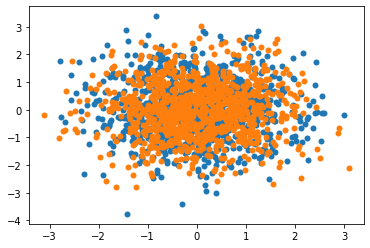

In [89]:
plt.scatter(Z_bayes_reduced[:,0], Z_bayes_reduced[:,1], lw=0.001)
plt.scatter(Z[:,0], Z[:,1], lw=0.001)
plt.show()

Алгоритм действительно оставил только два маленьких значения $\alpha$ и сработал корректно.